In [3]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# plotting
import matplotlib.pyplot as plt

# saving
import joblib

In [4]:
X_train = joblib.load('data/X_train_preprocessed.pkl')
X_test = joblib.load('data/X_test_preprocessed.pkl')
y_train = joblib.load('data/y_train_preprocessed.pkl')
y_test = joblib.load('data/y_test_preprocessed.pkl')

In [5]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [6]:
svc = SVC()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [9]:
param_grid = [
    # Kernel linear
    {
        'kernel': ['linear'],
        'C': [0.01, 0.1, 1, 10, 100]
    },
    # Kernel RBF (Gaussiano)
    {
        'kernel': ['rbf'],
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
    },
    # Kernel polinomial
    {
        'kernel': ['poly'],
        'C': [0.01, 0.1, 1, 10, 100],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'coef0': [0.0, 0.1, 0.5, 1.0]
    },
    # Kernel sigmoide
    {
        'kernel': ['sigmoid'],
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'coef0': [0.0, 0.1, 0.5, 1.0]
    }
]

In [10]:
def train_grid_search(X, y, estimator, grid):
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=grid,
        cv=skf,
        scoring=scoring,
        refit='f1_macro',
        n_jobs=-1,
        return_train_score=True
    )

    grid_search.fit(X, y)

    return grid_search

In [17]:
def get_results(g_search):
    results = pd.DataFrame(g_search.cv_results_)
    
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_kernel', 'param_C', 'param_degree',
            'param_gamma', 'param_coef0', 'mean_train_accuracy', 'mean_test_accuracy', 'rank_test_accuracy', 'mean_train_precision_macro', 
            'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 'mean_test_recall_macro', 
            'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [18]:
pd.set_option('display.max_columns', None)

In [19]:
grid_search = train_grid_search(X_train, y_train, svc, param_grid)
results = get_results(grid_search)

In [23]:
results.head(200)

,mean_fit_time,mean_score_time,param_kernel,param_C,param_degree,param_gamma,param_coef0,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
0,2.755161,0.080172,linear,0.01,NaN,NaN,NaN,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.00000,1.000000,1
211,1.486801,0.053184,poly,10,2,auto,0.0,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.00000,1.000000,1
242,4.758823,0.075244,poly,10,2,0.001,0.5,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.00000,1.000000,1
241,1.358019,0.040452,poly,10,2,auto,0.5,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.00000,1.000000,1
240,0.979042,0.039807,poly,10,2,scale,0.5,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,1.00000,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,4.075942,0.309608,rbf,100,NaN,0.1,NaN,1.000000,0.999829,188,1.000000,0.999898,188,1.000000,0.999479,188,1.00000,0.999687,188
164,1.080519,0.057225,poly,1,4,0.1,0.0,1.000000,0.999829,188,1.000000,0.999898,188,1.000000,0.999479,188,1.00000,0.999687,188
100,1.000427,0.048652,poly,0.1,4,scale,0.0,1.000000,0.999829,188,1.000000,0.999898,188,1.000000,0.999479,188,1.00000,0.999687,188
393,0.944727,0.033141,sigmoid,10,NaN,0.01,0.0,0.999829,0.999829,188,0.999898,0.999898,188,0.999482,0.999479,188,0.99969,0.999687,188


In [26]:
def view_test_metrics(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    param_cols = ['param_kernel', 'param_C', 'param_degree','param_gamma', 'param_coef0']
    plot_df = results_df.melt(
        id_vars=param_cols,      # keep these columns "as is"
        value_vars=metrics,      # the columns we want to "unpivot"
        var_name="metric",       # new column with the metric name
        value_name="score"       # new column with the metric value
    )

    plt.figure(figsize=(12, 8))


    for combo, group in plot_df.groupby(param_cols):
        # Sort the group by metric name (if desired)
        group = group.sort_values("metric")
        # Create a label for this parameter combination
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        
        # Separate train and test metrics using .str.startswith on the 'metric' column
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]

        # Plot training metrics with a dashed line and an 'x' marker (with transparency)
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     label=label_str + " (train)")
        # Plot test metrics with a solid line and an 'o' marker (with transparency)
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    # Adjust the legend to avoid cluttering the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()  

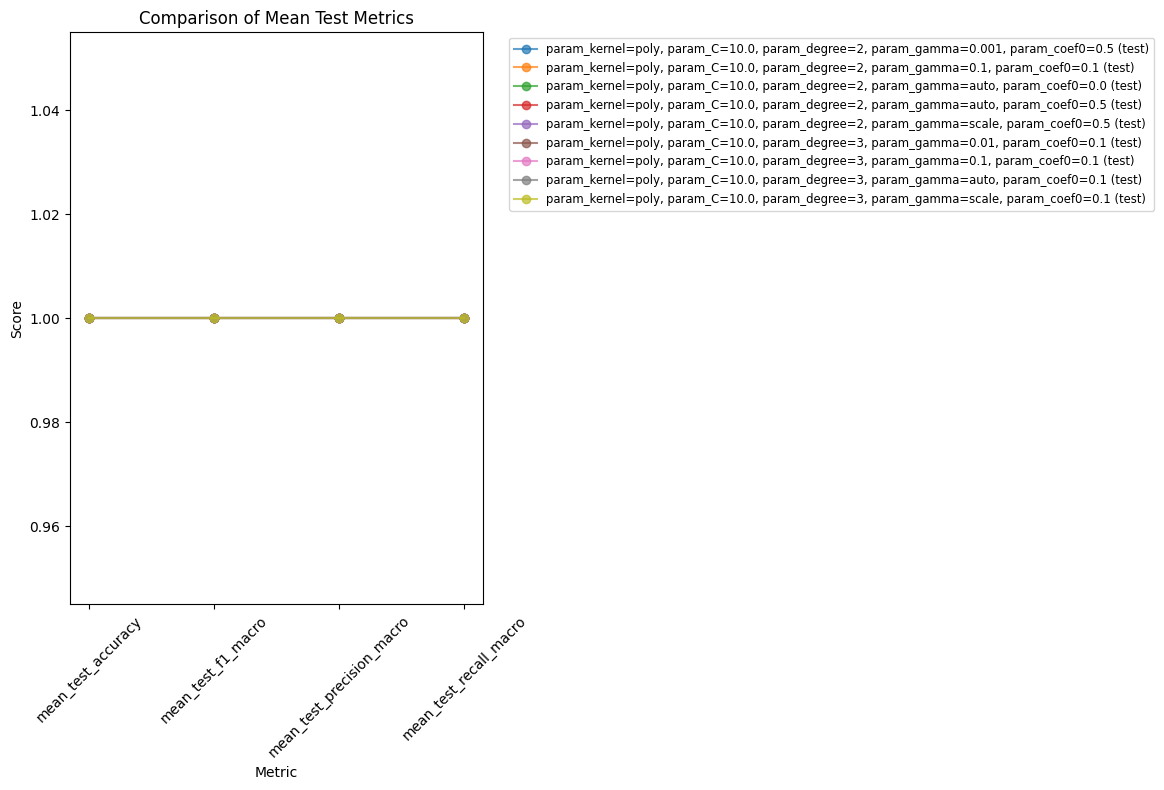

In [27]:
view_test_metrics(False, 10, results)

In [28]:
preds = cross_val_predict(grid_search.best_estimator_, X_train, y_train, cv=skf, n_jobs=-1)

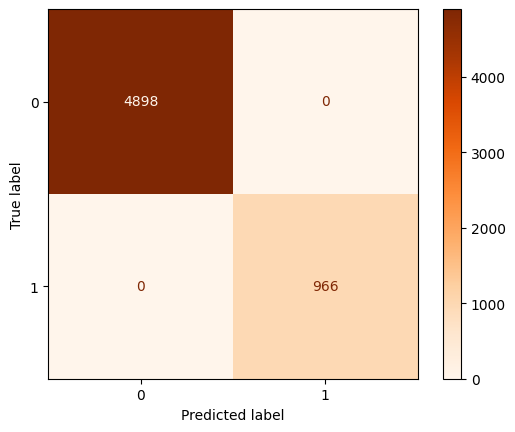

In [29]:
cm = confusion_matrix(y_train, preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=grid_search.best_estimator_.classes_)
cmd.plot(cmap=plt.cm.Oranges)
plt.show()

In [30]:
print(classification_report(y_train, preds, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      4898
           1     1.0000    1.0000    1.0000       966

    accuracy                         1.0000      5864
   macro avg     1.0000    1.0000    1.0000      5864
weighted avg     1.0000    1.0000    1.0000      5864



In [31]:
joblib.dump(grid_search.best_estimator_, 'models/svc.pkl')

['models/svc.pkl']